# Cuffless Blood Pressure Estimation - Model Prototyping

This notebook implements and evaluates various deep learning models for cuffless blood pressure estimation using PPG/ECG signals.

## 🎯 Model Architectures

1. **CNN-Based Models**
   - 1D CNN for feature extraction from physiological signals
   - Convolutional layers to capture temporal patterns
   - Feature maps for signal morphology analysis

2. **LSTM-Based Models**  
   - Long Short-Term Memory for temporal dependencies
   - Bidirectional LSTM for forward/backward signal analysis
   - Sequence-to-value regression

3. **Hybrid CNN-LSTM Models**
   - CNN for local feature extraction + LSTM for temporal modeling
   - Optimal combination for physiological signal processing
   - State-of-the-art performance for BP estimation

## 📊 Evaluation Metrics
- **Mean Absolute Error (MAE)**
- **Root Mean Square Error (RMSE)**
- **Mean Absolute Percentage Error (MAPE)**
- **Correlation Coefficient (R)**
- **Standard Deviation (STD)**

## 🔬 Experimental Setup
- Train/Validation/Test split: 70/15/15
- Cross-validation for robust evaluation
- Hyperparameter optimization
- Model comparison and selection

In [144]:
# =============================================================================
# 1. IMPORTS AND SETUP
# =============================================================================

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Deep learning framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    Bidirectional, Dropout, BatchNormalization, Flatten,
    TimeDistributed, Input, Concatenate
)

# Scikit-learn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Signal processing
from scipy import stats
from scipy.signal import butter, filtfilt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# TensorFlow configuration
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU'))} devices")

# Plot configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

TensorFlow version: 2.20.0
GPU available: 0 devices


In [145]:
# =============================================================================
# 2. DATA LOADING (MAT/HDF5) + AGGREGATION
# =============================================================================
import h5py
from scipy.io import loadmat

def _read_subj_wins(path, field='Subj_Wins', sample_limit=None):
    """Read per-window data from a MAT v7.3 'Subj_Wins' group without dereferencing the whole file.

    Extracts numeric Age, Gender, Height, and Weight per-window when available. Missing values
    are returned as np.nan (not 0) to avoid masking missingness.
    """
    signals = []
    sbps = []
    dbps = []
    ages = []
    genders = []
    heights = []
    weights = []
    with h5py.File(path, 'r') as f2:
        if field not in f2:
            raise KeyError(f'{field} not found in {path}')
        sw = f2[field]

        # Get signal references
        ppg_refs = sw.get('PPG_Raw')

        # Try common keys for ECG signal
        ecg_key_found = None
        for key in ['ECG_Raw', 'ECG_Raw_II', 'II', 'ECG', 'ecg']:
            if key in sw:
                ecg_key_found = key
                break

        if ppg_refs is None or ecg_key_found is None:
            raise KeyError(f'Could not find PPG_Raw or a valid ECG signal key in {list(sw.keys())}')

        ecg_refs = sw.get(ecg_key_found)

        n = ppg_refs.shape[1] if getattr(ppg_refs, 'ndim', 0) > 1 else ppg_refs.shape[0]
        if sample_limit is not None:
            n = min(int(n), int(sample_limit))

        for i in range(int(n)):
            # Dereference PPG signal
            ppg_ref = ppg_refs[0, i] if getattr(ppg_refs, 'ndim', 0) == 2 and ppg_refs.shape[0] == 1 else ppg_refs[i]
            try:
                ppg_sig = f2[ppg_ref][()] if isinstance(ppg_ref, h5py.Reference) else ppg_ref
            except Exception:
                ppg_sig = ppg_ref

            # Dereference ECG signal
            ecg_ref = ecg_refs[0, i] if getattr(ecg_refs, 'ndim', 0) == 2 and ecg_refs.shape[0] == 1 else ecg_refs[i]
            try:
                ecg_sig = f2[ecg_ref][()] if isinstance(ecg_ref, h5py.Reference) else ecg_ref
            except Exception:
                ecg_sig = ecg_ref

            # Combine signals into a (2, L) array
            sig = np.vstack([np.asarray(ppg_sig).ravel(), np.asarray(ecg_sig).ravel()])
            signals.append(sig)

            def _get_field_val(name):
                d = sw.get(name)
                if d is None:
                    return np.nan
                ref2 = d[0, i] if getattr(d, 'ndim', 0) == 2 and d.shape[0] == 1 else d[i]
                try:
                    val = f2[ref2][()]
                except Exception:
                    val = ref2
                arr = np.asarray(val)
                if arr.size == 1:
                    try:
                        return float(arr.item())
                    except Exception:
                        return np.nan
                return np.nan

            sbps.append(_get_field_val('SegSBP'))
            dbps.append(_get_field_val('SegDBP'))
            ages.append(_get_field_val('Age'))
            genders.append(_get_field_val('Gender'))
            heights.append(_get_field_val('Height'))
            weights.append(_get_field_val('Weight'))

    sigs = np.array(signals, dtype=object) if any(s.shape != signals[0].shape for s in signals) else np.stack(signals)

    sbp_arr = np.array(sbps, dtype=float)
    dbp_arr = np.array(dbps, dtype=float)
    age_arr = np.array(ages, dtype=float)

    def _gdecode(v):
        try:
            if v is None:
                return np.nan
            if isinstance(v, (bytes, bytearray)):
                s = v.decode(errors='ignore').strip().upper()
            elif isinstance(v, str):
                s = v.strip().upper()
            else:
                iv = float(v)
                if iv in (1.0, 0.0):
                    return iv
                if int(iv) in (77, 70):
                    s = chr(int(iv))
                else:
                    return np.nan
            return 1.0 if s == 'M' else 0.0 if s == 'F' else np.nan
        except Exception:
            return np.nan

    gender_arr = np.array([_gdecode(g) for g in genders], dtype=float)
    height_arr = np.array(heights, dtype=float)
    weight_arr = np.array(weights, dtype=float)

    demographics = np.column_stack([age_arr, gender_arr, height_arr, weight_arr])
    return sigs, sbp_arr, demographics


def load_aggregate_data():
    """Load and aggregate data from all patient .mat files."""
    processed_dir = Path('../data/processed')
    if not processed_dir.exists():
        print("❌ Processed data directory not found.")
        return None, None, None, None

    mat_files = sorted([f for f in os.listdir(processed_dir) if f.endswith('.mat')])
    if not mat_files:
        print("❌ No .mat files found in the processed data directory.")
        return None, None, None, None

    all_signals, all_labels, all_demographics, all_patient_ids = [], [], [], []

    print(f"🔄 Loading data from {len(mat_files)} patient files...")
    for file_name in mat_files:
        patient_id = file_name.split('.')[0]
        file_path = str(processed_dir / file_name)

        signals, sbp, demographics = None, None, None

        try:
            # First, try to load with scipy.io.loadmat for older MAT files
            data = loadmat(file_path, squeeze_me=True, struct_as_record=False)

            if 'Subj_Wins' in data:
                subset = data['Subj_Wins']
                ppg = subset.PPG_Raw
                ecg = subset.ECG_Raw
                # Ensure signals are correctly stacked
                signals = np.array([np.vstack([p.ravel(), e.ravel()]) for p, e in zip(ppg, ecg)])
                sbp = subset.SegSBP

                age = subset.Age
                gender = subset.Gender
                height = subset.Height
                weight = subset.Weight
                demographics = np.column_stack([age, gender, height, weight])
            else:
                print(f"   ❌ Could not find 'Subj_Wins' structure in {file_name} using scipy. Skipping file.")
                continue

        except Exception as e:
            # If scipy fails, check if it's an HDF5 file and use the h5py reader
            msg = str(e).lower()
            if 'hdf' in msg or '7.3' in msg or 'h5py' in msg:
                try:
                    signals, sbp, demographics = _read_subj_wins(file_path)
                except Exception as h5_e:
                    print(f"   ❌ Failed to load {file_name} with HDF5 reader. Error: {h5_e}")
                    continue
            else:
                print(f"   ❌ Failed to load {file_name} with scipy.io.loadmat. Error: {e}")
                continue

        if signals is not None and len(signals) > 0:
            all_signals.append(signals)
            all_labels.append(sbp)
            all_demographics.append(demographics)
            all_patient_ids.extend([patient_id] * len(signals))

    if not all_signals:
        print("❌ No data could be loaded from any files.")
        return None, None, None, None

    # Concatenate all data
    signals_agg = np.vstack(all_signals)
    labels_agg = np.concatenate(all_labels)
    demographics_agg = np.vstack(all_demographics)
    patient_ids_agg = np.array(all_patient_ids)

    # Filter out rows with NaN labels
    valid_indices = ~np.isnan(labels_agg)
    signals_agg = signals_agg[valid_indices]
    labels_agg = labels_agg[valid_indices]
    demographics_agg = demographics_agg[valid_indices]
    patient_ids_agg = patient_ids_agg[valid_indices]

    print(f"✅ Aggregated data loaded successfully!")
    print(f"   - Total signals: {signals_agg.shape}")
    print(f"   - Total labels: {labels_agg.shape}")
    print(f"   - Total demographics: {demographics_agg.shape}")
    print(f"   - Total patient IDs: {patient_ids_agg.shape}")
    print(f"   - Unique patients: {len(np.unique(patient_ids_agg))}")

    return signals_agg, labels_agg, demographics_agg, patient_ids_agg


# --- Workflow Step 1: Load aggregated data ---
signals_agg, labels_agg, demographics_agg, patient_ids_agg = load_aggregate_data()

🔄 Loading data from 4 patient files...
   ❌ Failed to load p001840.mat with scipy.io.loadmat. Error: Mat file appears to be truncated
✅ Aggregated data loaded successfully!
   - Total signals: (559, 2, 1250)
   - Total labels: (559,)
   - Total demographics: (559, 4)
   - Total patient IDs: (559,)
   - Unique patients: 3


In [146]:
# =============================================================================
# 3. SIGNAL PREPROCESSING (PPG/ECG)
# =============================================================================
def preprocess_signals(signals, target_length=875, sampling_rate=125):
    """Preprocess physiological signals for model input."""
    print("🔄 Preprocessing signals...")

    processed_signals_all = []
    for signal_window in signals:
        # Assuming channel 0 is PPG, channel 1 is ECG
        ppg_signal = signal_window[0, :]
        ecg_signal = signal_window[1, :]

        # PPG bandpass filtering (0.5-8 Hz)
        nyquist_ppg = sampling_rate / 2
        low_cut_ppg = 0.5 / nyquist_ppg
        high_cut_ppg = 8.0 / nyquist_ppg
        b_ppg, a_ppg = butter(4, [low_cut_ppg, high_cut_ppg], btype='band')
        filtered_ppg = filtfilt(b_ppg, a_ppg, ppg_signal)

        # ECG bandpass filtering (0.5-40 Hz)
        nyquist_ecg = sampling_rate / 2
        low_cut_ecg = 0.5 / nyquist_ecg
        high_cut_ecg = 40.0 / nyquist_ecg
        b_ecg, a_ecg = butter(4, [low_cut_ecg, high_cut_ecg], btype='band')
        filtered_ecg = filtfilt(b_ecg, a_ecg, ecg_signal)

        # Standardize length by truncating or padding
        def standardize_length(signal, length):
            if len(signal) > length:
                start_idx = (len(signal) - length) // 2
                return signal[start_idx:start_idx + length]
            padding = length - len(signal)
            pad_left = padding // 2
            pad_right = padding - pad_left
            return np.pad(signal, (pad_left, pad_right), mode='constant')

        processed_ppg = standardize_length(filtered_ppg, target_length)
        processed_ecg = standardize_length(filtered_ecg, target_length)

        processed_signals_all.append(np.stack([processed_ppg, processed_ecg], axis=0))

    processed_signals = np.array(processed_signals_all)

    # Normalization (Z-score per channel)
    mean = np.mean(processed_signals, axis=2, keepdims=True)
    std = np.std(processed_signals, axis=2, keepdims=True)
    processed_signals = (processed_signals - mean) / (std + 1e-8)

    # Transpose to (samples, timesteps, channels) for Keras
    processed_signals = np.transpose(processed_signals, (0, 2, 1))

    print(f"   - Signal preprocessing complete: {processed_signals.shape}")
    print(f"   - Target length: {target_length} samples ({target_length/sampling_rate:.1f} seconds)")
    return processed_signals


if signals_agg is not None:
    processed_signals = preprocess_signals(signals_agg)
    y = labels_agg
else:
    processed_signals = None
    y = None

🔄 Preprocessing signals...
   - Signal preprocessing complete: (559, 875, 2)
   - Target length: 875 samples (7.0 seconds)


In [147]:
# =============================================================================
# 4. SUBJECT-WISE SPLIT + DEMOGRAPHICS PREP
# =============================================================================
from sklearn.impute import SimpleImputer

def create_subject_wise_splits(patient_ids, test_size=0.2, val_size=0.2):
    """Creates train/validation/test splits that are subject-wise and returns boolean masks."""
    print("📊 Creating subject-wise data splits...")

    unique_patients = np.unique(patient_ids)
    n_patients = len(unique_patients)

    # Split patient IDs into train, val, test
    train_val_pids, test_pids = train_test_split(unique_patients, test_size=test_size, random_state=42)

    # Adjust val_size relative to the remaining pool of patients
    relative_val_size = val_size / (1 - test_size)
    train_pids, val_pids = train_test_split(train_val_pids, test_size=relative_val_size, random_state=42)

    print(f"   - Total unique patients: {n_patients}")
    print(f"   - Train patients: {len(train_pids)}")
    print(f"   - Validation patients: {len(val_pids)}")
    print(f"   - Test patients: {len(test_pids)}")

    train_mask = np.isin(patient_ids, train_pids)
    val_mask = np.isin(patient_ids, val_pids)
    test_mask = np.isin(patient_ids, test_pids)

    print(f"\n   - Train samples: {np.sum(train_mask)} ({np.sum(train_mask)/len(patient_ids)*100:.1f}%)")
    print(f"   - Validation samples: {np.sum(val_mask)} ({np.sum(val_mask)/len(patient_ids)*100:.1f}%)")
    print(f"   - Test samples: {np.sum(test_mask)} ({np.sum(test_mask)/len(patient_ids)*100:.1f}%)")
    return train_mask, val_mask, test_mask


if signals_agg is not None:
    train_mask, val_mask, test_mask = create_subject_wise_splits(patient_ids_agg)

    print("\n🔄 Imputing and scaling demographic data...")
    imputer = SimpleImputer(strategy='mean')
    scaler_demo = StandardScaler()

    demo_train_raw = demographics_agg[train_mask]
    demo_val_raw = demographics_agg[val_mask]
    demo_test_raw = demographics_agg[test_mask]

    demo_train = imputer.fit_transform(demo_train_raw)
    demo_train = scaler_demo.fit_transform(demo_train)

    demo_val = imputer.transform(demo_val_raw)
    demo_val = scaler_demo.transform(demo_val)

    demo_test = imputer.transform(demo_test_raw)
    demo_test = scaler_demo.transform(demo_test)

    print("   - Missing values and scaling handled for demographics.")
else:
    train_mask = val_mask = test_mask = None
    demo_train = demo_val = demo_test = None

📊 Creating subject-wise data splits...
   - Total unique patients: 3
   - Train patients: 1
   - Validation patients: 1
   - Test patients: 1

   - Train samples: 15 (2.7%)
   - Validation samples: 462 (82.6%)
   - Test samples: 82 (14.7%)

🔄 Imputing and scaling demographic data...
   - Missing values and scaling handled for demographics.


In [148]:
# =============================================================================
# 5. PHYSIOLOGICAL FEATURE EXTRACTION (PAT, HR)
# =============================================================================
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

def extract_physiological_features(ecg_signals, ppg_signals, sampling_rate=125):
    """Extract Pulse Arrival Time (PAT) and Heart Rate (HR) from ECG and PPG signals."""
    print("💓 Extracting physiological features (PAT, HR)...")

    all_pat_sequences = []
    all_hr_sequences = []
    all_peak_indices = {'r_peaks': [], 'ppg_feet': []}

    for i in range(ecg_signals.shape[0]):
        ecg = ecg_signals[i]
        ppg = ppg_signals[i]

        # --- R-peak detection for HR ---
        r_peaks, _ = find_peaks(ecg, height=np.mean(ecg) + 1.5 * np.std(ecg), distance=sampling_rate * 60/80)
        all_peak_indices['r_peaks'].append(r_peaks)

        hr_sequence = np.full_like(ecg, fill_value=np.nan)
        if len(r_peaks) > 1:
            instant_hr = sampling_rate * 60.0 / np.diff(r_peaks)
            interp_func = interp1d(r_peaks[1:], instant_hr, kind='linear', bounds_error=False, fill_value='extrapolate')
            hr_sequence = interp_func(np.arange(len(ecg)))
            hr_sequence = np.clip(hr_sequence, 40, 180)
        all_hr_sequences.append(hr_sequence)

        # --- PPG foot detection for PAT ---
        ppg_feet, _ = find_peaks(-ppg, distance=sampling_rate * 60/80)
        all_peak_indices['ppg_feet'].append(ppg_feet)

        # --- PAT calculation ---
        pat_sequence = np.full_like(ppg, fill_value=np.nan)
        if len(r_peaks) > 0 and len(ppg_feet) > 0:
            pat_values = []
            corresponding_r_peaks = []
            for r_peak in r_peaks:
                following_feet = ppg_feet[ppg_feet > r_peak]
                if len(following_feet) > 0:
                    pat = (following_feet[0] - r_peak) / sampling_rate
                    if 0.05 <= pat <= 0.5:
                        pat_values.append(pat)
                        corresponding_r_peaks.append(r_peak)
            if len(pat_values) > 1:
                interp_func = interp1d(corresponding_r_peaks, pat_values, kind='linear', bounds_error=False, fill_value='extrapolate')
                pat_sequence = interp_func(np.arange(len(ppg)))
                pat_sequence = np.clip(pat_sequence, 0.05, 0.5)
        all_pat_sequences.append(pat_sequence)

    pat_sequences = np.array(all_pat_sequences)
    hr_sequences = np.array(all_hr_sequences)

    # Fill remaining NaNs by forward/backward fill
    pat_sequences = pd.DataFrame(pat_sequences).ffill(axis=1).bfill(axis=1).to_numpy()
    hr_sequences = pd.DataFrame(hr_sequences).ffill(axis=1).bfill(axis=1).to_numpy()

    print(f"   - PAT sequences created with shape: {pat_sequences.shape}")
    print(f"   - HR sequences created with shape: {hr_sequences.shape}")
    return pat_sequences, hr_sequences, all_peak_indices

def standardize_feature_length(feature_sequences, target_length):
    """Standardize feature sequence length to match signal length."""
    standardized_features = []
    for seq in feature_sequences:
        if len(seq) > target_length:
            start_idx = (len(seq) - target_length) // 2
            standardized_features.append(seq[start_idx:start_idx + target_length])
        else:
            padding = target_length - len(seq)
            pad_left = padding // 2
            pad_right = padding - pad_left
            standardized_features.append(np.pad(seq, (pad_left, pad_right), mode='edge'))
    return np.array(standardized_features)


if signals_agg is not None:
    # Raw signals are (samples, channels, timesteps): channel 0 PPG, channel 1 ECG
    ppg_raw = signals_agg[:, 0, :]
    ecg_raw = signals_agg[:, 1, :]

    pat_seqs, hr_seqs, peak_indices = extract_physiological_features(ecg_raw, ppg_raw)

    # Standardize length to match processed_signals
    target_len = processed_signals.shape[1]
    pat_seqs = standardize_feature_length(pat_seqs, target_len)
    hr_seqs = standardize_feature_length(hr_seqs, target_len)
    print(f"   - Physiological features standardized to length: {target_len}")

    # Scale features using training split only
    print("\n🔄 Scaling physiological features (PAT, HR)...")
    scaler_pat = StandardScaler()
    scaler_hr = StandardScaler()
    scaler_pat.fit(pat_seqs[train_mask])
    scaler_hr.fit(hr_seqs[train_mask])
    pat_seqs_scaled = scaler_pat.transform(pat_seqs)
    hr_seqs_scaled = scaler_hr.transform(hr_seqs)
    print("   - Physiological features scaled.")
else:
    pat_seqs = hr_seqs = peak_indices = None
    pat_seqs_scaled = hr_seqs_scaled = None

💓 Extracting physiological features (PAT, HR)...
   - PAT sequences created with shape: (559, 1250)
   - HR sequences created with shape: (559, 1250)
   - Physiological features standardized to length: 875

🔄 Scaling physiological features (PAT, HR)...
   - Physiological features scaled.


🛠️  Creating features for baseline model...
   - Warning: NaN or Inf found in PAT sequences. Filling with 0.
   - Baseline features created with shape: (559, 4)

🤖 Training baseline Linear Regression model (subject-wise split)...
   - Baseline model trained.

✅ Baseline Model Evaluation (test):
   - Mean Absolute Error (MAE): 35.25
   - R^2 Score: -59.89

✅ Baseline Model Evaluation (val):
   - Mean Absolute Error (MAE): 32.44
   - R^2 Score: -6.93


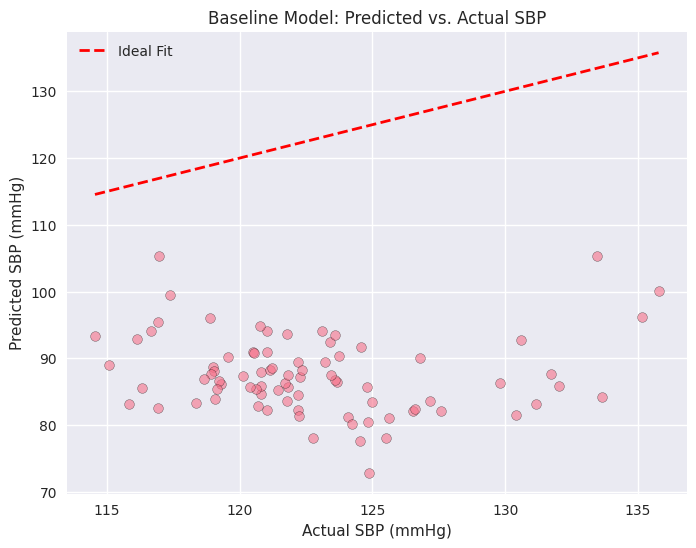

In [149]:
# =============================================================================
# PHASE 2: BASELINE MODEL (LINEAR REGRESSION ON PHYSIOLOGICAL FEATURES)
# =============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

def create_baseline_features(pat_sequences, hr_sequences, labels):
    """
    Creates a simple feature set for the baseline model.
    Features: mean PAT, std PAT, mean HR, std HR.
    """
    print("🛠️  Creating features for baseline model...")
    
    # Check for NaN/Inf values in inputs
    if np.any(np.isnan(pat_sequences)) or np.any(np.isinf(pat_sequences)):
        print("   - Warning: NaN or Inf found in PAT sequences. Filling with 0.")
        pat_sequences = np.nan_to_num(pat_sequences)
        
    if np.any(np.isnan(hr_sequences)) or np.any(np.isinf(hr_sequences)):
        print("   - Warning: NaN or Inf found in HR sequences. Filling with 0.")
        hr_sequences = np.nan_to_num(hr_sequences)

    mean_pat = np.mean(pat_sequences, axis=1)
    std_pat = np.std(pat_sequences, axis=1)
    mean_hr = np.mean(hr_sequences, axis=1)
    std_hr = np.std(hr_sequences, axis=1)
    
    X_baseline = np.column_stack([mean_pat, std_pat, mean_hr, std_hr])
    y_baseline = labels
    
    print(f"   - Baseline features created with shape: {X_baseline.shape}")
    return X_baseline, y_baseline

# Create features
X_baseline, y_baseline = create_baseline_features(pat_seqs, hr_seqs, y)

if X_baseline.shape[0] > 10:
    # Prefer subject-wise split (prevents patient leakage) if masks exist
    have_subject_masks = (
        'train_mask' in globals() and 'val_mask' in globals() and 'test_mask' in globals() and
        train_mask is not None and val_mask is not None and test_mask is not None
    )
    
    if have_subject_masks:
        X_base_train, y_base_train = X_baseline[train_mask], y_baseline[train_mask]
        X_base_val, y_base_val     = X_baseline[val_mask], y_baseline[val_mask]
        X_base_test, y_base_test   = X_baseline[test_mask], y_baseline[test_mask]
        split_name = "subject-wise"
    else:
        # Fallback: random split (less strict; can overestimate performance)
        from sklearn.model_selection import train_test_split
        X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(
            X_baseline, y_baseline, test_size=0.3, random_state=42
        )
        X_base_val, y_base_val = None, None
        split_name = "random"

    if X_base_train.shape[0] < 2 or X_base_test.shape[0] < 1:
        print("\n⚠️  Not enough data after splitting to train/evaluate the baseline model.")
    else:
        # Train model
        print(f"\n🤖 Training baseline Linear Regression model ({split_name} split)...")
        baseline_model = LinearRegression()
        baseline_model.fit(X_base_train, y_base_train)
        print("   - Baseline model trained.")

        # Evaluate model (test)
        y_base_pred = baseline_model.predict(X_base_test)
        mae = mean_absolute_error(y_base_test, y_base_pred)
        r2 = r2_score(y_base_test, y_base_pred)

        print(f"\n✅ Baseline Model Evaluation (test):")
        print(f"   - Mean Absolute Error (MAE): {mae:.2f}")
        print(f"   - R^2 Score: {r2:.2f}")

        # Optional: validation metrics when available
        if X_base_val is not None and X_base_val.shape[0] > 0:
            y_val_pred = baseline_model.predict(X_base_val)
            mae_val = mean_absolute_error(y_base_val, y_val_pred)
            r2_val = r2_score(y_base_val, y_val_pred)
            print(f"\n✅ Baseline Model Evaluation (val):")
            print(f"   - Mean Absolute Error (MAE): {mae_val:.2f}")
            print(f"   - R^2 Score: {r2_val:.2f}")

        # Plot results (test)
        plt.figure(figsize=(8, 6))
        plt.scatter(y_base_test, y_base_pred, alpha=0.6, edgecolors='k')
        plt.plot([min(y_base_test), max(y_base_test)], [min(y_base_test), max(y_base_test)], 'r--', lw=2, label='Ideal Fit')
        plt.title('Baseline Model: Predicted vs. Actual SBP')
        plt.xlabel('Actual SBP (mmHg)')
        plt.ylabel('Predicted SBP (mmHg)')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("\n⚠️  Not enough data to train and evaluate the baseline model.")

In [150]:
# =============================================================================
# PHASE 4: PHYSIOLOGY-INFORMED DEEP LEARNING MODEL (IMPROVED)
# =============================================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# Helpers: NaN/Inf safety
# -----------------------------
def _ensure_finite(name, arr):
    arr = np.asarray(arr)
    finite_mask = np.isfinite(arr)
    if finite_mask.all():
        return arr
    n_bad = arr.size - int(finite_mask.sum())
    print(f"⚠️ {name}: found {n_bad} non-finite values (NaN/Inf). Replacing with 0.")
    return np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)


def _ensure_finite_1d(name, y_arr):
    """Return (filtered_y, good_mask) where good_mask indexes the original y_arr."""
    y_arr = np.asarray(y_arr).reshape(-1)
    finite_mask = np.isfinite(y_arr)
    if finite_mask.all():
        return y_arr, finite_mask
    n_bad = y_arr.size - int(finite_mask.sum())
    print(f"⚠️ {name}: found {n_bad} non-finite labels. Dropping those samples.")
    return y_arr[finite_mask], finite_mask


# -----------------------------
# Step 1: Create 4-channel input
# -----------------------------
def create_4_channel_input(raw_signals, pat_sequences, hr_sequences):
    """
    Combines raw signals and physiological features into a 4-channel input.
    """
    print("🔄 Creating 4-channel input for the physiology-informed model...")

    pat_expanded = np.expand_dims(pat_sequences, axis=-1)
    hr_expanded = np.expand_dims(hr_sequences, axis=-1)

    X_phys_informed = np.concatenate([raw_signals, pat_expanded, hr_expanded], axis=-1)
    print(f"   - 4-channel input created with shape: {X_phys_informed.shape}")

    return X_phys_informed


# -----------------------------
# Step 2: Normalize Inputs (NaN-safe)
# -----------------------------
def normalize_data(X_train, X_val, X_test):
    mean = np.nanmean(X_train, axis=0)
    std = np.nanstd(X_train, axis=0) + 1e-8  # avoid division by zero
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std
    X_test_norm = (X_test - mean) / std
    # If anything is still non-finite (e.g., all-NaN timesteps), zero it out
    X_train_norm = np.nan_to_num(X_train_norm, nan=0.0, posinf=0.0, neginf=0.0)
    X_val_norm = np.nan_to_num(X_val_norm, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_norm = np.nan_to_num(X_test_norm, nan=0.0, posinf=0.0, neginf=0.0)
    return X_train_norm, X_val_norm, X_test_norm


# -----------------------------
# Step 3: Construct Model
# -----------------------------
def create_phys_informed_model(input_shape):
    """
    CNN + GRU model for 4-channel physiological input with BatchNorm and Dropout.
    """
    model = Sequential(
        [
            Conv1D(64, 5, activation="relu", input_shape=input_shape, padding="same"),
            BatchNormalization(),
            MaxPooling1D(2),
            Dropout(0.3),
            Conv1D(128, 5, activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling1D(2),
            Dropout(0.3),
            GRU(128, return_sequences=True),
            Dropout(0.3),
            GRU(64),
            Dropout(0.3),
            Dense(64, activation="relu"),
            Dense(1),
        ]
    )

    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss=Huber(), metrics=["mae"])
    return model


# -----------------------------
# Step 4: Prepare data
# -----------------------------
if signals_agg is not None:
    # Create 4-channel input
    X_phys_informed = create_4_channel_input(processed_signals, pat_seqs_scaled, hr_seqs_scaled)
    X_phys_informed = _ensure_finite("X_phys_informed (pre-split)", X_phys_informed)

    # Apply masks
    X_train_phys, y_train = X_phys_informed[train_mask], y[train_mask]
    X_val_phys, y_val = X_phys_informed[val_mask], y[val_mask]
    X_test_phys, y_test = X_phys_informed[test_mask], y[test_mask]

    # Ensure labels are finite (drop invalid samples if any)
    y_train, train_good = _ensure_finite_1d("y_train", y_train)
    y_val, val_good = _ensure_finite_1d("y_val", y_val)
    y_test, test_good = _ensure_finite_1d("y_test", y_test)
    X_train_phys = X_train_phys[train_good]
    X_val_phys = X_val_phys[val_good]
    X_test_phys = X_test_phys[test_good]

    # Ensure inputs are finite
    X_train_phys = _ensure_finite("X_train_phys (pre-norm)", X_train_phys)
    X_val_phys = _ensure_finite("X_val_phys (pre-norm)", X_val_phys)
    X_test_phys = _ensure_finite("X_test_phys (pre-norm)", X_test_phys)

    # Normalize
    X_train_phys, X_val_phys, X_test_phys = normalize_data(X_train_phys, X_val_phys, X_test_phys)

    print(f"\n🎯 Final data shapes:")
    print(f"   X_train: {X_train_phys.shape}, y_train: {y_train.shape}")
    print(f"   X_val:   {X_val_phys.shape}, y_val: {y_val.shape}")
    print(f"   X_test:  {X_test_phys.shape}, y_test: {y_test.shape}")

    # -----------------------------
    # Step 5: Create and Train Model
    # -----------------------------
    if X_train_phys.shape[0] < 2 or X_val_phys.shape[0] < 1:
        print("\n⚠️ Not enough data to train/validate the physiology-informed model after filtering.")
    else:
        phys_input_shape = (X_train_phys.shape[1], X_train_phys.shape[2])
        phys_informed_model = create_phys_informed_model(phys_input_shape)
        phys_informed_model.summary()

        # Callbacks
        early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)

        effective_batch_size = int(min(BATCH_SIZE, max(1, X_train_phys.shape[0])))
        if effective_batch_size != BATCH_SIZE:
            print(f"\nℹ️ Adjusting batch_size from {BATCH_SIZE} to {effective_batch_size} (tiny dataset).")

        # Train
        print("\n🏃‍♂️ Training Physiology-Informed Model...")
        phys_informed_history = phys_informed_model.fit(
            X_train_phys,
            y_train,
            validation_data=(X_val_phys, y_val),
            epochs=EPOCHS,
            batch_size=effective_batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=VERBOSE,
        )
        print("   - Training complete.")
else:
    print("\n⚠️ No data to train the physiology-informed model.")


🔄 Creating 4-channel input for the physiology-informed model...
   - 4-channel input created with shape: (559, 875, 4)
⚠️ X_phys_informed (pre-split): found 222250 non-finite values (NaN/Inf). Replacing with 0.

🎯 Final data shapes:
   X_train: (15, 875, 4), y_train: (15,)
   X_val:   (462, 875, 4), y_val: (462,)
   X_test:  (82, 875, 4), y_test: (82,)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_124 (Conv1D)             │ (None, 875, 64)        │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_230         │ (None, 875, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_94 (MaxPooling1D) │ (None, 437, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_186 (Dropout)           │ (None, 437, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_125 (Conv1D)             │ (None, 437, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_231         │ (None, 437, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_95 (MaxPooling1D) │ (None, 218, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_187 (Dropout)           │ (None, 218, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ (None, 218, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_188 (Dropout)           │ (None, 218, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_15 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_189 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,745 (717.75 KB)

 Trainable params: 183,361 (716.25 KB)

 Non-trainable params: 384 (1.50 KB)


ℹ️ Adjusting batch_size from 32 to 15 (tiny dataset).

🏃‍♂️ Training Physiology-Informed Model...
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 109.5246 - mae: 110.0246 - val_loss: 113.7620 - val_mae: 114.2620 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 109.4673 - mae: 109.9673 - val_loss: 113.7513 - val_mae: 114.2513 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 109.4497 - mae: 109.9497 - val_loss: 113.7413 - val_mae: 114.2413 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 109.2943 - mae: 109.7943 - val_loss: 113.7314 - val_mae: 114.2314 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 109.3157 - mae: 109.8157 - val_loss: 113.7217 - val_mae: 114.2217 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 109.1326 - mae: 109.6326 - val_loss: 113.7125 - val_mae: 114.2125 - learning_rate: 1.0000e-04
E